In [1]:
import os 
import numpy as np

from scripts.processing import predict, load_audio
import onnxruntime as ort
from onnxruntime import GraphOptimizationLevel
import matplotlib.pyplot as plt
import numpy as np

import os.path as osp
from psds_eval import PSDSEval, plot_psd_roc
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, recall_score,confusion_matrix, balanced_accuracy_score

In [26]:
model_type="CRNN" #select model YOLO / CRNN
providers=['CPUExecutionProvider']
quantize="_mixed"
reduction="True"

if reduction:
  opt_options = ort.SessionOptions()
  opt_options.graph_optimization_level = GraphOptimizationLevel.ORT_ENABLE_EXTENDED


if model_type=="YOLO":
  ort_sess = ort.InferenceSession('models/YOLOv5n'+quantize+'.onnx', opt_options, providers=providers)
  th=0.2 #Threshold of the confidence of the prediction
  print(os.path.getsize('models/YOLOv5n'+quantize+'.onnx')/ 1024**2)
elif model_type=="CRNN":
  ort_sess = ort.InferenceSession('models/CRNN'+quantize+'.onnx', opt_options,providers=providers)
  th=0.5 #Threshold of the confidence of the prediction
  print(os.path.getsize('models/CRNN'+quantize+'.onnx')/ 1024**2)

classes=["Horn","Siren","Pets","Physiological","Speech","RingTone","Vibrating","Notifications","Cry"] #List of predictions



2.5210037231445312


In [27]:
def plot_res(true_data, pred_data, name,dir):
    # Mapeo de clases a posiciones en y y colores
    class_positions = {
        'Speech': 10,
        'Hits': 20,
        "Horn":10,
        "Siren":20,
        "Pets":30,
        "Physiological":40,
        "Speech":50,
        "RingTone":60,
        "Vibrating":70,
        "Notifications":80,
        "Cry":90
    }

    # Crear la figura y el eje
    fig, ax = plt.subplots()

    bar_height = 4.5  # Altura de cada barra (la mitad del espacio total asignado)

    # Graficar datos verdaderos
    for onset, offset, cls, in true_data:
        ax.broken_barh([(float(onset), float(offset) - float(onset))],
                       (class_positions[cls], bar_height), facecolors='blue')

    # Graficar datos de predicción
    for onset, offset, cls, conf in pred_data:
        ax.broken_barh([(float(onset), float(offset) - float(onset))],
                       (class_positions[cls] - bar_height, bar_height), facecolors='black', alpha=float(conf))

    # Configurar el eje y las etiquetas
    
    ax.set_xlim(0, 10)
    ax.set_xlabel('Time')
    ax.set_yticks([pos for pos in class_positions.values()])
    ax.set_yticklabels(class_positions.keys())


    # Mostrar la gráfica
    plt.title(name)
    plt.grid(axis="x")
    
    plt.savefig(dir+"/figs/"+name.replace(".txt",".png"))
    plt.close()


def list2matrix(events,file_names):
    # Definir las clases de eventos y la resolución del frame
    frame_duration = 0.1  # Duración de cada frame en segundos

    # Obtener archivos únicos

    # Crear un diccionario para almacenar las matrices de frames por archivo
    file_frame_matrices = []

    for file_name in file_names:
        # Filtrar eventos para el archivo actual
        file_events = events[events[:, 3] == file_name]
        
        # Determinar el rango total de tiempo en el conjunto de eventos
        start_time = 0
        end_time = 10
        total_frames = int(np.ceil((end_time - start_time) / frame_duration))
        
        # Inicializar la matriz de frames para este archivo
        frame_matrix = np.zeros((len(classes), total_frames))

        # Mapear las clases a índices de fila
        class_index = {cls: idx for idx, cls in enumerate(classes)}

        # Llenar la matriz de frames
        for onset, offset, cls, _ in file_events:
            onset = float(onset)
            offset = float(offset)
            class_row = class_index[cls]

            # Convertir tiempos a índices de frame
            start_frame = int(np.floor((onset - start_time) / frame_duration))
            end_frame = int(np.ceil((offset - start_time) / frame_duration))
            
            # Asegurarse de que los índices de frame están dentro del rango
            start_frame = max(start_frame, 0)
            end_frame = min(end_frame, total_frames)
            
            # Llenar los frames correspondientes con 1s
            frame_matrix[class_row, start_frame:end_frame] = 1

        # Almacenar la matriz en el diccionario
        file_frame_matrices.append(frame_matrix)
    return file_frame_matrices

def filtrar(p):
    df = p.sort_values(by=["filename", "event_label", "onset"]).reset_index(drop=True)

    # Lista para almacenar los eventos fusionados
    merged_events = []

    # Inicializar el primer evento
    current_event = df.iloc[0].copy()

    # Iterar a través de los eventos para fusionarlos
    for i in range(1, len(df)):
        row = df.iloc[i]
        if row["filename"] == current_event["filename"] and row["event_label"] == current_event["event_label"] and row["onset"] <= current_event["offset"]:
            # Fusionar eventos solapados
            current_event["offset"] = max(current_event["offset"], row["offset"])
        else:
            # Añadir el evento actual a la lista y actualizar el evento actual
            merged_events.append(current_event)
            current_event = row.copy()

    # Añadir el último evento fusionado
    merged_events.append(current_event)

    # Crear un nuevo DataFrame con los eventos fusionados
    merged_df = pd.DataFrame(merged_events)
    return merged_df


In [28]:
taxonomy= {"Airplane":"None", 
           "Ambulance":'Siren',
            "Boat Horn":"Horn",
            "Car":"None", 
            "Car Horn":"Horn", 
            "Cat":"Pest", 
            "Cough":"Physiological", 
            "Crash":"None", 
            "Cry":"Cry",
            "Dirt":"None", 
            "Dog":"Pets", 
            "Door":"None", 
            "Drink":"None", 
            "Drift":"None",
            "Engine":"None",
            "Firefighter":'Siren',
            "Hail":"None",
            "Helicopter":"None", 
            "Hits":"None",
            "Ignition":"None",
            "Laughter":"None",
            "Manipulating Objects":"None", 
            "Microphone Noise":"None", 
            "Motorcycle":"None", 
            "Music":"None",
            "Notifications":"Notifications",
            "Pavement":"None", 
            "Police":"Siren",
            "Rain":"None", 
            "Ring Tone":"RingTone",
            "Sing":"None", 
            "Scream":"None", 
            "Sneeze":"Physiological", 
            "Speech":"Speech", 
            "Stone":"None",
            "Thunder":"None", 
            "Train":"None", 
            "Train Horn":"Horn", 
            "Truck":"None", 
            "Truck Horn":"Horn",
            "Vibrating":"Vibrating",
            "Yawn":"Physiological", 
            "Yell":"None",
            "Warning Beeps":"Notifications",
            "Window":"None", 
            "Wiper":"None"}

In [29]:
main_dir="c:/Users/Admin/Documents/RealAudio/"
mic="ZOOM0"

label_dir="labels_"+mic
audio_dir="audios_"+mic
res_name=mic+"_"+model_type
label_files=os.listdir(main_dir+"/"+label_dir)

In [30]:
try:
    os.makedirs(main_dir+"results/"+res_name)
except:
    pass

try:
    os.makedirs(main_dir+"results/"+res_name+"/"+quantize)
    
except:
    pass

try:
    os.makedirs(main_dir+"results/"+res_name+"/"+quantize+"/figs")
        
except:
    pass
    
fold_save=main_dir+"results/"+res_name+"/"+quantize+"/"


In [31]:
all_labels = []
all_predictions = []
times= []

for file in label_files:
    print(file)
    label=np.loadtxt(main_dir+"/"+label_dir+"/"+file, dtype=str, delimiter="	")
    
    if len(label.shape)==1:
        if label.shape[0]>0:
            label=label.reshape(1,-1)
        else:
            label=[[0,0,'Horn']]

    label = [[onset, offset, new_cls]
    for onset, offset, cls in label
    if (new_cls := taxonomy.get(cls, cls)) != "None"]

    label=np.array(label)

    if len(label)==0:
        label=np.array([[0,0,'Horn']])

    file_column = np.full((len(label), 1), file.replace(".txt",""), dtype=object)
    label_save = np.hstack((label, file_column))

    dir_audio=main_dir+"/"+audio_dir+"/"+file.replace(".txt",".wav")
    sr=16000
    audio=load_audio(dir_audio,sr)
    #audio=audio+load_audio("samples/Pavement_287.wav",sr)
    
    p_complete,t=predict(audio, ort_sess,model_type,0) #Do the prediction
    print(p_complete)
    times.append(float(str((t[2][2]-t[2][1])).split(":")[-1]))
    
    p_complete= np.array(np.round(p_complete,2),dtype=str)

    for row in p_complete:
        index = int(float(row[2]))
        row[2] = classes[index]

    file_column = np.full((p_complete.shape[0], 1), file.replace(".txt",""), dtype=object)
    
    p_complete = np.hstack((p_complete, file_column))

    p,_=predict(audio, ort_sess,model_type,th) #Do the prediction
    p= np.array(np.round(p,1),dtype=str)

    for row in p:
        index = int(float(row[2]))
        row[2] = classes[index]

    plot_res(label,p, file,fold_save)

    all_labels.append(label_save)
    all_predictions.append(p_complete)


ZOOM0010_Tr3_100___00_16_30---00_16_40.txt
[array([ 0.        , 10.        ,  0.        ,  0.03153445]), array([ 0.        , 10.        ,  1.        ,  0.06803358]), array([0.        , 0.12820513, 2.        , 0.02048903]), array([ 0.19230769, 10.        ,  2.        ,  0.02048903]), array([ 0.        , 10.        ,  3.        ,  0.03714779]), array([ 0.        , 10.        ,  4.        ,  0.14075743]), array([ 0.        , 10.        ,  5.        ,  0.38899145]), array([0.06410256, 0.76923077, 6.        , 0.00663066]), array([2.56410256, 3.20512821, 6.        , 0.00663066]), array([5.38461538, 5.76923077, 6.        , 0.00663066]), array([6.47435897, 6.6025641 , 6.        , 0.00663066]), array([6.66666667e+00, 6.79487179e+00, 6.00000000e+00, 6.63066236e-03]), array([6.85897436e+00, 7.75641026e+00, 6.00000000e+00, 6.63066236e-03]), array([9.42307692e+00, 1.00000000e+01, 6.00000000e+00, 6.63066236e-03]), array([0.00000000e+00, 1.02564103e+00, 7.00000000e+00, 5.22404164e-03]), array([1.4743

C:\Users\Admin\AppData\Local\Temp\ipykernel_6136\3233821585.py:7: UserWarning: loadtxt: input contained no data: "c:/Users/Admin/Documents/RealAudio//labels_ZOOM0/ZOOM0010_Tr3_112___00_18_30---00_18_40.txt"
  label=np.loadtxt(main_dir+"/"+label_dir+"/"+file, dtype=str, delimiter="	")
C:\Users\Admin\AppData\Local\Temp\ipykernel_6136\3233821585.py:7: UserWarning: loadtxt: input contained no data: "c:/Users/Admin/Documents/RealAudio//labels_ZOOM0/ZOOM0010_Tr3_113___00_18_40---00_18_50.txt"
  label=np.loadtxt(main_dir+"/"+label_dir+"/"+file, dtype=str, delimiter="	")


ZOOM0010_Tr3_113___00_18_40---00_18_50.txt
[array([ 0.        , 10.        ,  0.        ,  0.01282335]), array([ 0.        , 10.        ,  1.        ,  0.02447413]), array([ 0.        , 10.        ,  2.        ,  0.01082749]), array([0.00000000e+00, 1.00000000e+01, 3.00000000e+00, 7.13516958e-03]), array([0.00000000e+00, 1.00000000e+01, 4.00000000e+00, 9.95431002e-03]), array([ 0.        , 10.        ,  5.        ,  0.01676515]), array([0.        , 0.06410256, 6.        , 0.01250971]), array([3.97435897, 4.48717949, 6.        , 0.01250971]), array([ 9.67948718, 10.        ,  6.        ,  0.01250971]), array([0.00000000e+00, 1.92307692e-01, 7.00000000e+00, 5.44867525e-03]), array([1.15384615e+00, 1.28205128e+00, 7.00000000e+00, 5.44867525e-03]), array([1.66666667e+00, 1.98717949e+00, 7.00000000e+00, 5.44867525e-03]), array([2.05128205e+00, 2.24358974e+00, 7.00000000e+00, 5.44867525e-03]), array([2.30769231e+00, 2.37179487e+00, 7.00000000e+00, 5.44867525e-03]), array([2.56410256e+00, 3.6

C:\Users\Admin\AppData\Local\Temp\ipykernel_6136\3233821585.py:7: UserWarning: loadtxt: input contained no data: "c:/Users/Admin/Documents/RealAudio//labels_ZOOM0/ZOOM0010_Tr3_121___00_20_00---00_20_10.txt"
  label=np.loadtxt(main_dir+"/"+label_dir+"/"+file, dtype=str, delimiter="	")
C:\Users\Admin\AppData\Local\Temp\ipykernel_6136\3233821585.py:7: UserWarning: loadtxt: input contained no data: "c:/Users/Admin/Documents/RealAudio//labels_ZOOM0/ZOOM0010_Tr3_122___00_20_10---00_20_20.txt"
  label=np.loadtxt(main_dir+"/"+label_dir+"/"+file, dtype=str, delimiter="	")


ZOOM0010_Tr3_122___00_20_10---00_20_20.txt
[array([ 0.       , 10.       ,  0.       ,  0.0336301]), array([ 0.        , 10.        ,  1.        ,  0.02342631]), array([0.00000000e+00, 1.00000000e+01, 2.00000000e+00, 7.06032524e-03]), array([0.00000000e+00, 1.00000000e+01, 3.00000000e+00, 6.58630999e-03]), array([0.00000000e+00, 1.00000000e+01, 4.00000000e+00, 8.08319915e-03]), array([ 0.        , 10.        ,  5.        ,  0.01908533]), array([0.        , 0.19230769, 6.        , 0.00738465]), array([4.42307692, 5.25641026, 6.        , 0.00738465]), array([5.32051282, 5.76923077, 6.        , 0.00738465]), array([6.85897436e+00, 7.43589744e+00, 6.00000000e+00, 7.38465087e-03]), array([9.55128205e+00, 1.00000000e+01, 6.00000000e+00, 7.38465087e-03]), array([0.00000000e+00, 2.05128205e+00, 7.00000000e+00, 5.25408005e-03]), array([2.24358974e+00, 2.37179487e+00, 7.00000000e+00, 5.25408005e-03]), array([4.67948718e+00, 4.74358974e+00, 7.00000000e+00, 5.25408005e-03]), array([4.87179487e+00,

C:\Users\Admin\AppData\Local\Temp\ipykernel_6136\3233821585.py:7: UserWarning: loadtxt: input contained no data: "c:/Users/Admin/Documents/RealAudio//labels_ZOOM0/ZOOM0010_Tr3_125___00_20_40---00_20_50.txt"
  label=np.loadtxt(main_dir+"/"+label_dir+"/"+file, dtype=str, delimiter="	")
C:\Users\Admin\AppData\Local\Temp\ipykernel_6136\3233821585.py:7: UserWarning: loadtxt: input contained no data: "c:/Users/Admin/Documents/RealAudio//labels_ZOOM0/ZOOM0010_Tr3_126___00_20_50---00_21_00.txt"
  label=np.loadtxt(main_dir+"/"+label_dir+"/"+file, dtype=str, delimiter="	")


ZOOM0010_Tr3_126___00_20_50---00_21_00.txt
[array([ 0.       , 10.       ,  0.       ,  0.0154928]), array([ 0.        , 10.        ,  1.        ,  0.01132646]), array([0.        , 0.12820513, 2.        , 0.02477286]), array([0.83333333, 0.8974359 , 2.        , 0.02477286]), array([1.08974359, 1.6025641 , 2.        , 0.02477286]), array([3.14102564, 3.46153846, 2.        , 0.02477286]), array([3.58974359, 3.78205128, 2.        , 0.02477286]), array([ 3.84615385, 10.        ,  2.        ,  0.02477286]), array([ 0.        , 10.        ,  3.        ,  0.01067781]), array([ 0.      , 10.      ,  4.      ,  0.013472]), array([ 0.        , 10.        ,  5.        ,  0.01713938]), array([5.19230769, 5.8974359 , 6.        , 0.01264871]), array([ 9.67948718, 10.        ,  6.        ,  0.01264871]), array([0.        , 0.19230769, 7.        , 0.00748444]), array([4.74358974, 5.        , 7.        , 0.00748444]), array([5.19230769, 6.08974359, 7.        , 0.00748444]), array([9.67948718e+00, 1.000

C:\Users\Admin\AppData\Local\Temp\ipykernel_6136\3233821585.py:7: UserWarning: loadtxt: input contained no data: "c:/Users/Admin/Documents/RealAudio//labels_ZOOM0/ZOOM0010_Tr3_156___00_25_50---00_26_00.txt"
  label=np.loadtxt(main_dir+"/"+label_dir+"/"+file, dtype=str, delimiter="	")


ZOOM0010_Tr3_158___00_26_10---00_26_20.txt
[array([ 0.        , 10.        ,  0.        ,  0.03011241]), array([ 0.        , 10.        ,  1.        ,  0.08160538]), array([ 0.       , 10.       ,  2.       ,  0.0121248]), array([ 0.        , 10.        ,  3.        ,  0.12207127]), array([ 0.        , 10.        ,  4.        ,  0.69273502]), array([ 0.        , 10.        ,  5.        ,  0.02255312]), array([2.94871795e+00, 3.20512821e+00, 6.00000000e+00, 5.36985183e-03]), array([4.29487179e+00, 8.71794872e+00, 6.00000000e+00, 5.36985183e-03]), array([9.61538462e+00, 1.00000000e+01, 6.00000000e+00, 5.36985183e-03]), array([0.00000000e+00, 6.41025641e-02, 7.00000000e+00, 5.87200560e-03]), array([5.76923077e-01, 9.61538462e-01, 7.00000000e+00, 5.87200560e-03]), array([4.61538462e+00, 5.57692308e+00, 7.00000000e+00, 5.87200560e-03]), array([6.92307692e+00, 8.26923077e+00, 7.00000000e+00, 5.87200560e-03]), array([8.39743590e+00, 8.78205128e+00, 7.00000000e+00, 5.87200560e-03]), array([8.9

C:\Users\Admin\AppData\Local\Temp\ipykernel_6136\3233821585.py:7: UserWarning: loadtxt: input contained no data: "c:/Users/Admin/Documents/RealAudio//labels_ZOOM0/ZOOM0010_Tr3_161___00_26_40---00_26_50.txt"
  label=np.loadtxt(main_dir+"/"+label_dir+"/"+file, dtype=str, delimiter="	")


ZOOM0010_Tr3_163___00_27_00---00_27_10.txt
[array([0.00000000e+00, 1.00000000e+01, 0.00000000e+00, 9.62998345e-03]), array([ 0.        , 10.        ,  1.        ,  0.02315188]), array([ 0.        , 10.        ,  2.        ,  0.02043253]), array([ 0.        , 10.        ,  3.        ,  0.12152241]), array([ 0.        , 10.        ,  4.        ,  0.79260254]), array([ 0.      , 10.      ,  5.      ,  0.032233]), array([8.26923077, 8.71794872, 6.        , 0.00972978]), array([9.67948718e+00, 1.00000000e+01, 6.00000000e+00, 9.72977560e-03]), array([0.        , 0.51282051, 7.        , 0.00926645]), array([8.33333333, 8.78205128, 7.        , 0.00926645]), array([9.61538462e+00, 1.00000000e+01, 7.00000000e+00, 9.26645286e-03]), array([ 0.        , 10.        ,  8.        ,  0.01187532])]
ZOOM0010_Tr3_164___00_27_10---00_27_20.txt
[array([ 0.        , 10.        ,  0.        ,  0.01127656]), array([ 0.        , 10.        ,  1.        ,  0.01921007]), array([ 3.46153846, 10.        ,  2.      

C:\Users\Admin\AppData\Local\Temp\ipykernel_6136\3233821585.py:7: UserWarning: loadtxt: input contained no data: "c:/Users/Admin/Documents/RealAudio//labels_ZOOM0/ZOOM0010_Tr3_192___00_31_50---00_32_00.txt"
  label=np.loadtxt(main_dir+"/"+label_dir+"/"+file, dtype=str, delimiter="	")
C:\Users\Admin\AppData\Local\Temp\ipykernel_6136\3233821585.py:7: UserWarning: loadtxt: input contained no data: "c:/Users/Admin/Documents/RealAudio//labels_ZOOM0/ZOOM0010_Tr3_193___00_32_00---00_32_10.txt"
  label=np.loadtxt(main_dir+"/"+label_dir+"/"+file, dtype=str, delimiter="	")


ZOOM0010_Tr3_194___00_32_10---00_32_20.txt
[array([ 0.        , 10.        ,  0.        ,  0.01165078]), array([ 0.        , 10.        ,  1.        ,  0.02197931]), array([0.        , 0.06410256, 2.        , 0.0275732 ]), array([2.11538462, 2.17948718, 2.        , 0.0275732 ]), array([ 2.56410256, 10.        ,  2.        ,  0.0275732 ]), array([ 0.        , 10.        ,  3.        ,  0.07150137]), array([ 0.        , 10.        ,  4.        ,  0.33161074]), array([ 0.        , 10.        ,  5.        ,  0.01666536]), array([6.15384615, 6.47435897, 6.        , 0.01187033]), array([7.88461538, 7.94871795, 6.        , 0.01187033]), array([8.01282051, 8.33333333, 6.        , 0.01187033]), array([ 9.42307692, 10.        ,  6.        ,  0.01187033]), array([6.08974359, 6.66666667, 7.        , 0.00956761]), array([9.03846154e+00, 1.00000000e+01, 7.00000000e+00, 9.56761371e-03]), array([0.        , 0.12820513, 8.        , 0.01539989]), array([ 2.69230769, 10.        ,  8.        ,  0.01539989

C:\Users\Admin\AppData\Local\Temp\ipykernel_6136\3233821585.py:7: UserWarning: loadtxt: input contained no data: "c:/Users/Admin/Documents/RealAudio//labels_ZOOM0/ZOOM0010_Tr3_204___00_33_50---00_34_00.txt"
  label=np.loadtxt(main_dir+"/"+label_dir+"/"+file, dtype=str, delimiter="	")


ZOOM0010_Tr3_206___00_34_10---00_34_20.txt
[array([ 0.        , 10.        ,  0.        ,  0.01661546]), array([ 0.        , 10.        ,  1.        ,  0.01798761]), array([0.        , 0.38461538, 2.        , 0.00586607]), array([1.53846154e+00, 1.00000000e+01, 2.00000000e+00, 5.86606842e-03]), array([0.00000000e+00, 1.00000000e+01, 3.00000000e+00, 6.53641438e-03]), array([0.00000000e+00, 7.50000000e+00, 4.00000000e+00, 5.64176217e-03]), array([8.65384615e+00, 8.78205128e+00, 4.00000000e+00, 5.64176217e-03]), array([9.35897436e+00, 1.00000000e+01, 4.00000000e+00, 5.64176217e-03]), array([ 0.        , 10.        ,  5.        ,  0.02000841]), array([0.        , 0.12820513, 6.        , 0.01897306]), array([ 9.61538462, 10.        ,  6.        ,  0.01897306]), array([0.        , 0.19230769, 7.        , 0.01132192]), array([7.17948718, 7.30769231, 7.        , 0.01132192]), array([ 9.61538462, 10.        ,  7.        ,  0.01132192]), array([0.00000000e+00, 2.56410256e-01, 8.00000000e+00, 4.5

C:\Users\Admin\AppData\Local\Temp\ipykernel_6136\3233821585.py:7: UserWarning: loadtxt: input contained no data: "c:/Users/Admin/Documents/RealAudio//labels_ZOOM0/ZOOM0010_Tr3_206___00_34_10---00_34_20.txt"
  label=np.loadtxt(main_dir+"/"+label_dir+"/"+file, dtype=str, delimiter="	")


ZOOM0010_Tr3_208___00_34_30---00_34_40.txt
[array([0.00000000e+00, 1.00000000e+01, 0.00000000e+00, 9.25576128e-03]), array([ 0.       , 10.       ,  1.       ,  0.0175136]), array([0.        , 0.44871795, 2.        , 0.01423246]), array([1.47435897, 3.91025641, 2.        , 0.01423246]), array([3.97435897, 4.03846154, 2.        , 0.01423246]), array([4.1025641 , 4.16666667, 2.        , 0.01423246]), array([ 4.23076923, 10.        ,  2.        ,  0.01423246]), array([ 0.        , 10.        ,  3.        ,  0.03906879]), array([ 0.        , 10.        ,  4.        ,  0.16378458]), array([ 0.       , 10.       ,  5.       ,  0.0161664]), array([0.        , 0.32051282, 6.        , 0.00930674]), array([2.24358974, 2.75641026, 6.        , 0.00930674]), array([9.35897436e+00, 1.00000000e+01, 6.00000000e+00, 9.30674188e-03]), array([0.        , 0.19230769, 7.        , 0.00825557]), array([2.17948718, 3.01282051, 7.        , 0.00825557]), array([8.52564103e+00, 8.71794872e+00, 7.00000000e+00, 8.

C:\Users\Admin\AppData\Local\Temp\ipykernel_6136\3233821585.py:7: UserWarning: loadtxt: input contained no data: "c:/Users/Admin/Documents/RealAudio//labels_ZOOM0/ZOOM0010_Tr3_211___00_35_00---00_35_10.txt"
  label=np.loadtxt(main_dir+"/"+label_dir+"/"+file, dtype=str, delimiter="	")
C:\Users\Admin\AppData\Local\Temp\ipykernel_6136\3233821585.py:7: UserWarning: loadtxt: input contained no data: "c:/Users/Admin/Documents/RealAudio//labels_ZOOM0/ZOOM0010_Tr3_212___00_35_10---00_35_20.txt"
  label=np.loadtxt(main_dir+"/"+label_dir+"/"+file, dtype=str, delimiter="	")


ZOOM0010_Tr3_212___00_35_10---00_35_20.txt
[array([ 0.       , 10.       ,  0.       ,  0.0308858]), array([ 0.        , 10.        ,  1.        ,  0.02090655]), array([0.        , 0.38461538, 2.        , 0.0111498 ]), array([2.82051282, 3.26923077, 2.        , 0.0111498 ]), array([3.97435897, 4.03846154, 2.        , 0.0111498 ]), array([5.8974359 , 5.96153846, 2.        , 0.0111498 ]), array([7.11538462, 7.62820513, 2.        , 0.0111498 ]), array([7.69230769, 7.75641026, 2.        , 0.0111498 ]), array([8.91025641, 9.03846154, 2.        , 0.0111498 ]), array([ 9.29487179, 10.        ,  2.        ,  0.0111498 ]), array([0.00000000e+00, 1.00000000e+01, 3.00000000e+00, 6.36177743e-03]), array([0.        , 2.11538462, 4.        , 0.00555987]), array([2.17948718, 2.24358974, 4.        , 0.00555987]), array([2.30769231, 3.26923077, 4.        , 0.00555987]), array([3.84615385, 4.03846154, 4.        , 0.00555987]), array([4.1025641 , 4.16666667, 4.        , 0.00555987]), array([4.23076923, 4

C:\Users\Admin\AppData\Local\Temp\ipykernel_6136\3233821585.py:7: UserWarning: loadtxt: input contained no data: "c:/Users/Admin/Documents/RealAudio//labels_ZOOM0/ZOOM0010_Tr3_213___00_35_20---00_35_30.txt"
  label=np.loadtxt(main_dir+"/"+label_dir+"/"+file, dtype=str, delimiter="	")


ZOOM0010_Tr3_214___00_35_30---00_35_40.txt
[array([ 0.        , 10.        ,  0.        ,  0.01232438]), array([ 0.        , 10.        ,  1.        ,  0.02060717]), array([3.84615385e-01, 1.00000000e+01, 2.00000000e+00, 8.92544817e-03]), array([ 0.        , 10.        ,  3.        ,  0.03487751]), array([ 0.        , 10.        ,  4.        ,  0.55292571]), array([ 0.        , 10.        ,  5.        ,  0.02200427]), array([0.8974359 , 1.02564103, 6.        , 0.00709701]), array([2.05128205, 2.24358974, 6.        , 0.00709701]), array([2.30769231, 3.14102564, 6.        , 0.00709701]), array([7.30769231e+00, 7.56410256e+00, 6.00000000e+00, 7.09701329e-03]), array([7.69230769e+00, 8.01282051e+00, 6.00000000e+00, 7.09701329e-03]), array([9.55128205e+00, 1.00000000e+01, 6.00000000e+00, 7.09701329e-03]), array([2.43589744, 2.56410256, 7.        , 0.01089735]), array([ 9.48717949, 10.        ,  7.        ,  0.01089735]), array([0.00000000e+00, 1.00000000e+01, 8.00000000e+00, 6.01250352e-03]

C:\Users\Admin\AppData\Local\Temp\ipykernel_6136\3233821585.py:7: UserWarning: loadtxt: input contained no data: "c:/Users/Admin/Documents/RealAudio//labels_ZOOM0/ZOOM0010_Tr3_220___00_36_30---00_36_40.txt"
  label=np.loadtxt(main_dir+"/"+label_dir+"/"+file, dtype=str, delimiter="	")


ZOOM0010_Tr3_221___00_36_40---00_36_50.txt
[array([0.00000000e+00, 1.00000000e+01, 0.00000000e+00, 9.20586661e-03]), array([ 0.        , 10.        ,  1.        ,  0.01185037]), array([0.        , 0.06410256, 2.        , 0.01360808]), array([ 0.8974359 , 10.        ,  2.        ,  0.01360808]), array([ 0.        , 10.        ,  3.        ,  0.26380166]), array([ 0.        , 10.        ,  4.        ,  0.51250976]), array([ 0.        , 10.        ,  5.        ,  0.01911028]), array([4.87179487, 5.        , 6.        , 0.01245411]), array([ 9.48717949, 10.        ,  6.        ,  0.01245411]), array([3.26923077, 3.33333333, 7.        , 0.00889579]), array([9.16666667e+00, 1.00000000e+01, 7.00000000e+00, 8.89579486e-03]), array([ 0.        , 10.        ,  8.        ,  0.02220385])]
ZOOM0010_Tr3_222___00_36_50---00_37_00.txt
[array([0.00000000e+00, 1.00000000e+01, 0.00000000e+00, 8.08319822e-03]), array([ 0.        , 10.        ,  1.        ,  0.01150109]), array([1.47435897, 1.98717949, 2. 

C:\Users\Admin\AppData\Local\Temp\ipykernel_6136\3233821585.py:7: UserWarning: loadtxt: input contained no data: "c:/Users/Admin/Documents/RealAudio//labels_ZOOM0/ZOOM0010_Tr3_67___00_11_00---00_11_10.txt"
  label=np.loadtxt(main_dir+"/"+label_dir+"/"+file, dtype=str, delimiter="	")
C:\Users\Admin\AppData\Local\Temp\ipykernel_6136\3233821585.py:7: UserWarning: loadtxt: input contained no data: "c:/Users/Admin/Documents/RealAudio//labels_ZOOM0/ZOOM0010_Tr3_68___00_11_10---00_11_20.txt"
  label=np.loadtxt(main_dir+"/"+label_dir+"/"+file, dtype=str, delimiter="	")


ZOOM0010_Tr3_69___00_11_20---00_11_30.txt
[array([ 0.        , 10.        ,  0.        ,  0.01122666]), array([ 0.        , 10.        ,  1.        ,  0.01456972]), array([ 0.76923077, 10.        ,  2.        ,  0.03735153]), array([ 0.        , 10.        ,  3.        ,  0.07362197]), array([ 0.        , 10.        ,  4.        ,  0.03929333]), array([ 0.        , 10.        ,  5.        ,  0.03205837]), array([1.21794872, 1.34615385, 6.        , 0.01167573]), array([ 9.67948718, 10.        ,  6.        ,  0.01167573]), array([8.33333333e-01, 1.47435897e+00, 7.00000000e+00, 6.45487616e-03]), array([3.07692308e+00, 3.14102564e+00, 7.00000000e+00, 6.45487616e-03]), array([7.82051282e+00, 7.94871795e+00, 7.00000000e+00, 6.45487616e-03]), array([8.20512821e+00, 1.00000000e+01, 7.00000000e+00, 6.45487616e-03]), array([ 0.        , 10.        ,  8.        ,  0.01327241])]
ZOOM0010_Tr3_6___00_00_50---00_01_00.txt
[array([0.00000000e+00, 1.00000000e+01, 0.00000000e+00, 6.91063656e-03]), array

C:\Users\Admin\AppData\Local\Temp\ipykernel_6136\3233821585.py:7: UserWarning: loadtxt: input contained no data: "c:/Users/Admin/Documents/RealAudio//labels_ZOOM0/ZOOM0011_Tr3_128___00_21_10---00_21_20.txt"
  label=np.loadtxt(main_dir+"/"+label_dir+"/"+file, dtype=str, delimiter="	")
C:\Users\Admin\AppData\Local\Temp\ipykernel_6136\3233821585.py:7: UserWarning: loadtxt: input contained no data: "c:/Users/Admin/Documents/RealAudio//labels_ZOOM0/ZOOM0011_Tr3_129___00_21_20---00_21_30.txt"
  label=np.loadtxt(main_dir+"/"+label_dir+"/"+file, dtype=str, delimiter="	")


ZOOM0011_Tr3_12___00_01_50---00_02_00.txt
[array([ 0.        , 10.        ,  0.        ,  0.01788782]), array([ 0.        , 10.        ,  1.        ,  0.16450806]), array([ 0.        , 10.        ,  2.        ,  0.03338062]), array([ 0.        , 10.        ,  3.        ,  0.09313142]), array([ 0.       , 10.       ,  4.       ,  0.2686666]), array([ 0.        , 10.        ,  5.        ,  0.07918541]), array([1.92307692, 1.98717949, 6.        , 0.00843247]), array([3.78205128, 3.91025641, 6.        , 0.00843247]), array([4.80769231, 4.87179487, 6.        , 0.00843247]), array([7.62820513, 8.14102564, 6.        , 0.00843247]), array([8.20512821e+00, 8.58974359e+00, 6.00000000e+00, 8.43247306e-03]), array([8.65384615e+00, 8.71794872e+00, 6.00000000e+00, 8.43247306e-03]), array([9.29487179e+00, 1.00000000e+01, 6.00000000e+00, 8.43247306e-03]), array([0.        , 0.06410256, 7.        , 0.00985951]), array([0.19230769, 0.25641026, 7.        , 0.00985951]), array([0.32051282, 0.38461538, 7. 

C:\Users\Admin\AppData\Local\Temp\ipykernel_6136\3233821585.py:7: UserWarning: loadtxt: input contained no data: "c:/Users/Admin/Documents/RealAudio//labels_ZOOM0/ZOOM0011_Tr3_146___00_24_10---00_24_20.txt"
  label=np.loadtxt(main_dir+"/"+label_dir+"/"+file, dtype=str, delimiter="	")


ZOOM0011_Tr3_148___00_24_30---00_24_40.txt
[array([0.00000000e+00, 1.00000000e+01, 0.00000000e+00, 9.85451695e-03]), array([ 0.        , 10.        ,  1.        ,  0.21425468]), array([ 0.        , 10.        ,  2.        ,  0.02225375]), array([ 0.        , 10.        ,  3.        ,  0.03061138]), array([ 0.        , 10.        ,  4.        ,  0.89381725]), array([ 0.        , 10.        ,  5.        ,  0.02769244]), array([0.        , 0.32051282, 6.        , 0.01259147]), array([2.30769231, 2.56410256, 6.        , 0.01259147]), array([ 9.48717949, 10.        ,  6.        ,  0.01259147]), array([0.        , 0.76923077, 7.        , 0.00968231]), array([2.30769231, 2.5       , 7.        , 0.00968231]), array([8.33333333e+00, 1.00000000e+01, 7.00000000e+00, 9.68231354e-03]), array([ 0.        , 10.        ,  8.        ,  0.01000421])]
ZOOM0011_Tr3_149___00_24_40---00_24_50.txt
[array([ 0.        , 10.        ,  0.        ,  0.01012895]), array([ 0.        , 10.        ,  1.        ,  0.1

C:\Users\Admin\AppData\Local\Temp\ipykernel_6136\3233821585.py:7: UserWarning: loadtxt: input contained no data: "c:/Users/Admin/Documents/RealAudio//labels_ZOOM0/ZOOM0011_Tr3_37___00_06_00---00_06_10.txt"
  label=np.loadtxt(main_dir+"/"+label_dir+"/"+file, dtype=str, delimiter="	")
C:\Users\Admin\AppData\Local\Temp\ipykernel_6136\3233821585.py:7: UserWarning: loadtxt: input contained no data: "c:/Users/Admin/Documents/RealAudio//labels_ZOOM0/ZOOM0011_Tr3_38___00_06_10---00_06_20.txt"
  label=np.loadtxt(main_dir+"/"+label_dir+"/"+file, dtype=str, delimiter="	")


ZOOM0011_Tr3_38___00_06_10---00_06_20.txt
[array([ 0.        , 10.        ,  0.        ,  0.03380473]), array([ 0.        , 10.        ,  1.        ,  0.01170068]), array([0.        , 0.06410256, 2.        , 0.00597363]), array([0.76923077, 1.08974359, 2.        , 0.00597363]), array([1.41025641, 2.5       , 2.        , 0.00597363]), array([2.56410256, 2.82051282, 2.        , 0.00597363]), array([3.14102564, 3.3974359 , 2.        , 0.00597363]), array([3.46153846, 3.97435897, 2.        , 0.00597363]), array([4.93589744, 5.06410256, 2.        , 0.00597363]), array([5.76923077e+00, 7.75641026e+00, 2.00000000e+00, 5.97363105e-03]), array([7.94871795e+00, 8.07692308e+00, 2.00000000e+00, 5.97363105e-03]), array([8.26923077e+00, 8.33333333e+00, 2.00000000e+00, 5.97363105e-03]), array([9.29487179e+00, 1.00000000e+01, 2.00000000e+00, 5.97363105e-03]), array([0.0000000e+00, 1.0000000e+01, 3.0000000e+00, 5.7630213e-03]), array([0.        , 2.75641026, 4.        , 0.00568343]), array([3.07692308,

C:\Users\Admin\AppData\Local\Temp\ipykernel_6136\3233821585.py:7: UserWarning: loadtxt: input contained no data: "c:/Users/Admin/Documents/RealAudio//labels_ZOOM0/ZOOM0011_Tr3_41___00_06_40---00_06_50.txt"
  label=np.loadtxt(main_dir+"/"+label_dir+"/"+file, dtype=str, delimiter="	")


ZOOM0011_Tr3_43___00_07_00---00_07_10.txt
[array([ 0.        , 10.        ,  0.        ,  0.01394601]), array([ 0.        , 10.        ,  1.        ,  0.01060296]), array([0.        , 0.06410256, 2.        , 0.0392074 ]), array([0.8974359 , 3.20512821, 2.        , 0.0392074 ]), array([ 5.44871795, 10.        ,  2.        ,  0.0392074 ]), array([ 0.        , 10.        ,  3.        ,  0.09273225]), array([ 0.        , 10.        ,  4.        ,  0.08222909]), array([ 0.        , 10.        ,  5.        ,  0.04740148]), array([1.47435897, 1.79487179, 6.        , 0.00880801]), array([7.88461538, 8.20512821, 6.        , 0.00880801]), array([9.10256410e+00, 9.29487179e+00, 6.00000000e+00, 8.80800840e-03]), array([9.61538462e+00, 1.00000000e+01, 6.00000000e+00, 8.80800840e-03]), array([0.00000000e+00, 6.41025641e-02, 7.00000000e+00, 6.95354678e-03]), array([1.41025641e+00, 2.17948718e+00, 7.00000000e+00, 6.95354678e-03]), array([2.24358974e+00, 2.30769231e+00, 7.00000000e+00, 6.95354678e-03])

C:\Users\Admin\AppData\Local\Temp\ipykernel_6136\3233821585.py:7: UserWarning: loadtxt: input contained no data: "c:/Users/Admin/Documents/RealAudio//labels_ZOOM0/ZOOM0011_Tr3_75___00_12_20---00_12_30.txt"
  label=np.loadtxt(main_dir+"/"+label_dir+"/"+file, dtype=str, delimiter="	")
C:\Users\Admin\AppData\Local\Temp\ipykernel_6136\3233821585.py:7: UserWarning: loadtxt: input contained no data: "c:/Users/Admin/Documents/RealAudio//labels_ZOOM0/ZOOM0011_Tr3_76___00_12_30---00_12_40.txt"
  label=np.loadtxt(main_dir+"/"+label_dir+"/"+file, dtype=str, delimiter="	")


ZOOM0011_Tr3_76___00_12_30---00_12_40.txt
[array([ 0.        , 10.        ,  0.        ,  0.01439508]), array([ 0.        , 10.        ,  1.        ,  0.01491899]), array([1.92307692e-01, 7.56410256e+00, 2.00000000e+00, 6.95575541e-03]), array([8.33333333e+00, 1.00000000e+01, 2.00000000e+00, 6.95575541e-03]), array([0.00000000e+00, 1.00000000e+01, 3.00000000e+00, 6.31188042e-03]), array([ 0.        , 10.        ,  4.        ,  0.01047822]), array([ 0.        , 10.        ,  5.        ,  0.02746791]), array([ 9.67948718, 10.        ,  6.        ,  0.01945955]), array([0.00000000e+00, 6.41025641e-02, 7.00000000e+00, 4.57871845e-03]), array([2.56410256e-01, 3.01282051e+00, 7.00000000e+00, 4.57871845e-03]), array([3.26923077e+00, 5.06410256e+00, 7.00000000e+00, 4.57871845e-03]), array([5.12820513e+00, 5.32051282e+00, 7.00000000e+00, 4.57871845e-03]), array([6.08974359e+00, 1.00000000e+01, 7.00000000e+00, 4.57871845e-03]), array([0.00000000e+00, 1.00000000e+01, 8.00000000e+00, 4.36592568e-0

C:\Users\Admin\AppData\Local\Temp\ipykernel_6136\3233821585.py:7: UserWarning: loadtxt: input contained no data: "c:/Users/Admin/Documents/RealAudio//labels_ZOOM0/ZOOM0011_Tr3_82___00_13_30---00_13_40.txt"
  label=np.loadtxt(main_dir+"/"+label_dir+"/"+file, dtype=str, delimiter="	")


ZOOM0011_Tr3_83___00_13_40---00_13_50.txt
[array([ 0.       , 10.       ,  0.       ,  0.0127485]), array([ 0.        , 10.        ,  1.        ,  0.01217469]), array([0.        , 0.12820513, 2.        , 0.02635529]), array([ 0.57692308, 10.        ,  2.        ,  0.02635529]), array([ 0.        , 10.        ,  3.        ,  0.01831194]), array([ 0.        , 10.        ,  4.        ,  0.15343107]), array([ 0.        , 10.        ,  5.        ,  0.01589197]), array([2.11538462, 2.37179487, 6.        , 0.01214276]), array([7.69230769, 8.46153846, 6.        , 0.01214276]), array([ 9.42307692, 10.        ,  6.        ,  0.01214276]), array([1.73076923, 1.79487179, 7.        , 0.01377137]), array([ 8.3974359 , 10.        ,  7.        ,  0.01377137]), array([0.        , 0.19230769, 8.        , 0.00967081]), array([0.38461538, 0.57692308, 8.        , 0.00967081]), array([0.64102564, 0.70512821, 8.        , 0.00967081]), array([1.53846154, 1.85897436, 8.        , 0.00967081]), array([3.65384615

In [32]:
p_complete_final = np.vstack(all_predictions) 
label_save_final = np.vstack(all_labels)  # Unir todas las matrices de etiquetas

In [33]:
label_names=[l.replace(".txt","") for l in label_files]

In [34]:
label_save_final=label_save_final[(label_save_final[:,1].astype(float)-label_save_final[:,0].astype(float))>0.0]
p_complete_final=p_complete_final[(p_complete_final[:,1].astype(float)-p_complete_final[:,0].astype(float))>0.0]

In [35]:
np.save(fold_save+"predictions_list",p_complete_final)
np.save(fold_save+"labels_list",label_save_final)

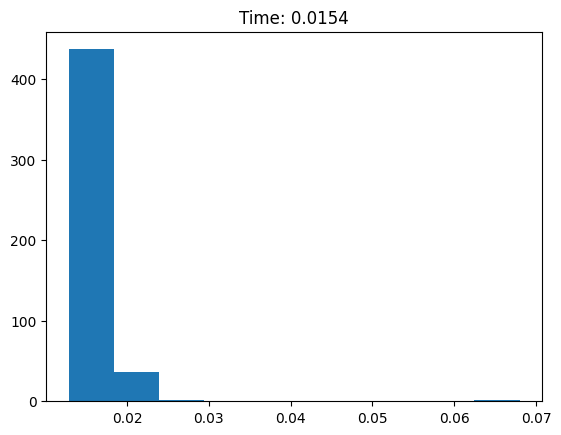

In [36]:
np.save(fold_save+"prediction_times",times)
plt.hist(times, bins=10)
plt.title("Time: "+str(np.round(np.mean(times),4)))
plt.savefig(fold_save+"prediction_times.png")

In [37]:
fold_save

'c:/Users/Admin/Documents/RealAudio/results/ZOOM0_CRNN/_mixed/'

In [38]:
predictions_list=np.load(fold_save+"predictions_list.npy",allow_pickle=True)
labels_list=np.load(fold_save+"labels_list.npy",allow_pickle=True)

In [39]:
predictions_list.shape

(7921, 5)

In [40]:
#Frame metrics
true_matriz=np.array(list2matrix(labels_list,label_names))
true_matriz=true_matriz.transpose(1,2,0).reshape(9,-1)
print(true_matriz.shape)

acc_list_th = []
f1_list_th = []
recall_list_th = []
fpr_list_th = []

for th in np.arange(0,1,0.02):
    print(th)
    p_aux=predictions_list[predictions_list[:,3].astype(float)>th]
    pred_matriz=np.array(list2matrix(p_aux[:,[0,1,2,4]],label_names))
    pred_matriz=pred_matriz.transpose(1,2,0).reshape(9,-1)
    
    acc_list = []
    f1_list = []
    recall_list = []
    fpr_list = []

    # Calcular las métricas para cada categoría (fila)
    for i in range(true_matriz.shape[0]):
        acc = balanced_accuracy_score(true_matriz[i], pred_matriz[i])
        f1 = f1_score(true_matriz[i], pred_matriz[i])
        recall = recall_score(true_matriz[i], pred_matriz[i])
        
        if len(np.unique(true_matriz[i]))==1:
            fpr=1
               
        else:
            tn, fp, fn, tp = confusion_matrix(true_matriz[i], pred_matriz[i]).ravel()
            print(tn, fp, fn, tp)
            fpr = fp / (fp + tn)
            print(recall,fpr)
            
        
        acc_list.append(acc)
        f1_list.append(f1)
        recall_list.append(recall)
        fpr_list.append(fpr)

    pred_matriz_all=pred_matriz.reshape(-1)
    true_matriz_all=true_matriz.reshape(-1)
    
    acc = balanced_accuracy_score(true_matriz_all, pred_matriz_all)
    f1 = f1_score(true_matriz_all, pred_matriz_all)
    recall = recall_score(true_matriz_all, pred_matriz_all)
    
    if len(np.unique(true_matriz[i]))==1:
        fpr=1
        
    else:
        tn, fp, fn, tp = confusion_matrix(true_matriz_all,pred_matriz_all).ravel()
        fpr = fp / (fp + tn)

    acc_list.append(acc)
    f1_list.append(f1)
    recall_list.append(recall)
    fpr_list.append(fpr)

    acc_list_th.append(acc_list)
    f1_list_th.append(f1_list)
    recall_list_th.append(recall_list)
    fpr_list_th.append(fpr_list)







(9, 47500)
0.0
9 47443 0 48
1.0 0.9998103346539661
0 47111 0 389
1.0 1.0
3330 44120 0 50
1.0 0.9298208640674394
362 47096 0 42
1.0 0.9923722027898352
1257 13181 47 33015
0.9985784284072349 0.9129380800664912
0 46754 0 746
1.0 1.0


c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


32698 14061 434 307
0.4143049932523617 0.3007121623644646
6595 40051 0 854
1.0 0.8586159584959053
0.02
41800 5652 0 48
1.0 0.11910983730928096
24811 22300 89 300
0.7712082262210797 0.47335017299569104
40651 6799 0 50
1.0 0.14328767123287672
10209 37249 14 28
0.6666666666666666 0.7848834759155464
5300 9138 963 32099
0.970872905450366 0.6329131458650783
26058 20696 342 404
0.5415549597855228 0.4426573127432947
46384 375 676 65
0.08771929824561403 0.008019846446673367


c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


37400 9246 0 854
1.0 0.1982163529563092
0.04
45389 2063 11 37
0.7708333333333334 0.04347551209643429
35211 11900 89 300
0.7712082262210797 0.2525949353654136
45085 2365 0 50
1.0 0.04984193888303477
15047 32411 23 19
0.4523809523809524 0.6829407054658856
5680 8758 1764 31298
0.9466456959651564 0.6065937110403103
38901 7853 499 247
0.33109919571045576 0.16796423835393762
46404 355 676 65
0.08771929824561403 0.007592121302850788


c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


41400 5246 0 854
1.0 0.11246409124040646
0.06
46069 1383 31 17
0.3541666666666667 0.029145241507207282
38911 8200 89 300
0.7712082262210797 0.17405701428541104
46044 1406 6 44
0.88 0.029631190727081137
20429 27029 23 19
0.4523809523809524 0.5695351679379662
5933 8505 2711 30351
0.9180025406811445 0.5890705083806621
41288 5466 512 234
0.3136729222520107 0.11690978312016084


c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


46404 355 676 65
0.08771929824561403 0.007592121302850788
42300 4346 0 854
1.0 0.09316983235432834
0.08
46369 1083 31 17
0.3541666666666667 0.02282306330607772
41211 5900 89 300
0.7712082262210797 0.12523614442486894
46527 923 23 27
0.54 0.019452054794520546
24622 22836 23 19
0.4523809523809524 0.4811833621307261
6239 8199 3005 30057
0.9091101566753372 0.5678764371796647
42488 4266 512 234
0.3136729222520107 0.09124352996535055


c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


46404 355 676 65
0.08771929824561403 0.007592121302850788
43300 3346 0 854
1.0 0.07173176692535266
0.1
46769 683 31 17
0.3541666666666667 0.014393492371238305
42511 4600 89 300
0.7712082262210797 0.09764173972108425
46907 543 23 27
0.54 0.011443624868282402
29217 18241 23 19
0.4523809523809524 0.38436090859286104
6594 7844 3219 29843
0.9026374689976407 0.5432885441196842
43047 3707 553 193
0.2587131367292225 0.0792873337040681
46475 284 680 61
0.08232118758434548 0.006073697042280631


c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


43700 2946 0 854
1.0 0.06315654075376238
0.12
46952 500 48 0
0.0 0.010536963668549271
43311 3800 89 300
0.7712082262210797 0.08066056759567829
46987 463 43 7
0.14 0.009757639620653319
32817 14641 23 19
0.4523809523809524 0.30850436175144336
6814 7624 3399 29663
0.8971931522593914 0.5280509765895554
43247 3507 553 193
0.2587131367292225 0.07500962484493305
46475 284 680 61
0.08232118758434548 0.006073697042280631


c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


44100 2546 0 854
1.0 0.05458131458217211
0.14
47152 300 48 0
0.0 0.006322178201129562
44011 3100 89 300
0.7712082262210797 0.06580204198594808
47266 184 50 0
0.0 0.0038777660695468916
35684 11774 23 19
0.4523809523809524 0.2480930506974588
7130 7308 4183 28879
0.8734801282439054 0.5061642886826431
43447 3307 553 193
0.2587131367292225 0.070731915985798
46475 284 680 61
0.08232118758434548 0.006073697042280631


c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


44648 1998 52 802
0.9391100702576113 0.04283325472709343
0.16
47152 300 48 0
0.0 0.006322178201129562
44811 2300 89 300
0.7712082262210797 0.048820869860542127
47350 100 50 0
0.0 0.002107481559536354
38179 9279 23 19
0.4523809523809524 0.19552024948375404
7647 6791 4766 28296
0.8558465912527978 0.47035600498684027
43911 2843 589 157
0.21045576407506703 0.060807631432604696
46614 145 691 50
0.06747638326585695 0.003101007292713702


c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


45148 1498 52 802
0.9391100702576113 0.03211422201260558
0.18
47152 300 48 0
0.0 0.006322178201129562
44911 2200 89 300
0.7712082262210797 0.04669822334486638
47350 100 50 0
0.0 0.002107481559536354
39479 7979 23 19
0.4523809523809524 0.16812760756879766
7748 6690 5265 27797
0.8407537354062066 0.4633605762570993
44111 2643 589 157
0.21045576407506703 0.05652992257346965
46614 145 691 50
0.06747638326585695 0.003101007292713702


c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


45148 1498 52 802
0.9391100702576113 0.03211422201260558
0.2
47252 200 48 0
0.0 0.004214785467419708
45211 1900 89 300
0.7712082262210797 0.04033028379783914
47350 100 50 0
0.0 0.002107481559536354
41358 6100 42 0
0.0 0.12853470437017994
8045 6393 5865 27197
0.8226060129453754 0.4427898600914254
44411 2343 589 157
0.21045576407506703 0.05011335928476708
46614 145 691 50
0.06747638326585695 0.003101007292713702


c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


45448 1198 52 802
0.9391100702576113 0.025682802383912875
0.22
47252 200 48 0
0.0 0.004214785467419708
45611 1500 89 300
0.7712082262210797 0.03183969773513617
47450 0 50 0
0.0 0.0
42458 5000 42 0
0.0 0.10535631505752455
8542 5896 6468 26594
0.8043675518722401 0.40836680980745255
44411 2343 589 157
0.21045576407506703 0.05011335928476708
46643 116 701 40
0.05398110661268556 0.002480805834170962


c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


45548 1098 52 802
0.9391100702576113 0.023538995841015306
0.24
47252 200 48 0
0.0 0.004214785467419708
45611 1500 189 200
0.5141388174807198 0.03183969773513617
47450 0 50 0
0.0 0.0
43658 3800 42 0
0.0 0.08007079944371866
8828 5610 6782 26280
0.7948702437844051 0.38855797201828507
44511 2243 589 157
0.21045576407506703 0.04797450485519956
46643 116 701 40
0.05398110661268556 0.002480805834170962
45548 1098 52 802
0.9391100702576113 0.023538995841015306


c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.26
47252 200 48 0
0.0 0.004214785467419708
46011 1100 189 200
0.5141388174807198 0.02334911167243319
47450 0 50 0
0.0 0.0
44358 3100 42 0
0.0 0.06532091533566523
9174 5264 7336 25726
0.7781138467122376 0.3645934339936279
44811 1943 589 157
0.21045576407506703 0.04155794156649698
46643 116 701 40
0.05398110661268556 0.002480805834170962


c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


45548 1098 52 802
0.9391100702576113 0.023538995841015306
0.28
47352 100 48 0
0.0 0.002107392733709854
46211 900 189 200
0.5141388174807198 0.0191038186410817
47450 0 50 0
0.0 0.0
45458 2000 42 0
0.0 0.042142526023009816
9611 4827 8096 24966
0.7551267315951848 0.33432608394514474
44811 1943 589 157
0.21045576407506703 0.04155794156649698
46643 116 701 40
0.05398110661268556 0.002480805834170962


c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


45548 1098 52 802
0.9391100702576113 0.023538995841015306
0.3
47352 100 48 0
0.0 0.002107392733709854
46211 900 189 200
0.5141388174807198 0.0191038186410817
47450 0 50 0
0.0 0.0
45558 1900 42 0
0.0 0.04003539972185933
9707 4731 8400 24662
0.7459318855483636 0.3276769635683613
45011 1743 589 157
0.21045576407506703 0.037280232707361936
46643 116 701 40
0.05398110661268556 0.002480805834170962
45648 998 52 802
0.9391100702576113 0.021395189298117737


c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.32
47352 100 48 0
0.0 0.002107392733709854
46411 700 189 200
0.5141388174807198 0.014858525609730212
47450 0 50 0
0.0 0.0
45858 1600 42 0
0.0 0.03371402081840785
9923 4515 9079 23983
0.7253947129635231 0.3127164427205984
45111 1643 589 157
0.21045576407506703 0.03514137827779441
46691 68 714 27
0.03643724696356275 0.0014542654889967708


c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


45748 898 52 802
0.9391100702576113 0.01925138275522017
0.34
47352 100 48 0
0.0 0.002107392733709854
46411 700 189 200
0.5141388174807198 0.014858525609730212
47450 0 50 0
0.0 0.0
46258 1200 42 0
0.0 0.025285515613805893
10137 4301 9363 23699
0.7168047909987296 0.2978944452140186
45243 1511 657 89
0.1193029490616622 0.032318090430765285
46722 37 730 11
0.014844804318488529 0.0007912915160717723


c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


45748 898 52 802
0.9391100702576113 0.01925138275522017
0.36
47352 100 48 0
0.0 0.002107392733709854
46411 700 189 200
0.5141388174807198 0.014858525609730212
47450 0 50 0
0.0 0.0
46458 1000 42 0
0.0 0.021071263011504908
10265 4173 9635 23427
0.7085778234831529 0.28902895137830725
45343 1411 657 89
0.1193029490616622 0.03017923600119776
46722 37 730 11
0.014844804318488529 0.0007912915160717723


c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


45848 798 52 802
0.9391100702576113 0.0171075762123226
0.38
47352 100 48 0
0.0 0.002107392733709854
46511 600 189 200
0.5141388174807198 0.012735879094054468
47450 0 50 0
0.0 0.0
46758 700 42 0
0.0 0.014749884108053437
10640 3798 10760 22302
0.6745508438690945 0.26305582490649676
45443 1311 657 89
0.1193029490616622 0.028040381571630236


c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


46722 37 730 11
0.014844804318488529 0.0007912915160717723
45848 798 52 802
0.9391100702576113 0.0171075762123226
0.4
47452 0 48 0
0.0 0.0
46511 600 189 200
0.5141388174807198 0.012735879094054468
47450 0 50 0
0.0 0.0
46958 500 42 0
0.0 0.010535631505752454
11042 3396 11458 21604
0.6534389934063275 0.2352126333287159
45543 1211 657 89
0.1193029490616622 0.025901527142062713
46759 0 741 0
0.0 0.0


c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


45881 765 119 735
0.860655737704918 0.016400120053166403
0.42
47452 0 48 0
0.0 0.0
46511 600 189 200
0.5141388174807198 0.012735879094054468
47450 0 50 0
0.0 0.0
47058 400 42 0
0.0 0.008428505204601963
11229 3209 11871 21191
0.6409473111124554 0.22226070092810638
45543 1211 657 89
0.1193029490616622 0.025901527142062713


c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


46759 0 741 0
0.0 0.0
45881 765 119 735
0.860655737704918 0.016400120053166403
0.44
47452 0 48 0
0.0 0.0
46611 500 189 200
0.5141388174807198 0.010613232578378722
47450 0 50 0
0.0 0.0
47058 400 42 0
0.0 0.008428505204601963
11404 3034 12496 20566
0.6220434335490896 0.21013990857459483
45543 1211 657 89
0.1193029490616622 0.025901527142062713
46759 0 741 0
0.0 0.0
45881 765 119 735
0.860655737704918 0.016400120053166403


c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.46
47452 0 48 0
0.0 0.0
46611 500 289 100
0.2570694087403599 0.010613232578378722
47450 0 50 0
0.0 0.0
47158 300 42 0
0.0 0.006321378903451473
11529 2909 13171 19891
0.6016272457806545 0.20148219975065798
45554 1200 746 0
0.0 0.025666253154810283
46759 0 741 0
0.0 0.0
45937 709 163 691
0.8091334894613583 0.015199588389143764


c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.48
47452 0 48 0
0.0 0.0
46611 500 289 100
0.2570694087403599 0.010613232578378722
47450 0 50 0
0.0 0.0
47158 300 42 0
0.0 0.006321378903451473
11637 2801 14063 18999
0.5746476317222189 0.19400193932677656
45654 1100 746 0
0.0 0.02352739872524276
46759 0 741 0
0.0 0.0
46037 609 163 691
0.8091334894613583 0.013055781846246195


c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.5
47452 0 48 0
0.0 0.0
46611 500 289 100
0.2570694087403599 0.010613232578378722
47450 0 50 0
0.0 0.0
47158 300 42 0
0.0 0.006321378903451473
11805 2633 14795 18267
0.5525074103200048 0.18236597866740545
45654 1100 746 0
0.0 0.02352739872524276


c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


46759 0 741 0
0.0 0.0
46037 609 163 691
0.8091334894613583 0.013055781846246195
0.52
47452 0 48 0
0.0 0.0
46611 500 289 100
0.2570694087403599 0.010613232578378722
47450 0 50 0
0.0 0.0
47158 300 42 0
0.0 0.006321378903451473
11870 2568 15430 17632
0.5333010707156252 0.1778639700789583
45854 900 746 0
0.0 0.019249689866107714
46759 0 741 0
0.0 0.0


c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


46037 609 263 591
0.6920374707259953 0.013055781846246195
0.54
47452 0 48 0
0.0 0.0
46811 300 289 100
0.2570694087403599 0.006367939547027234
47450 0 50 0
0.0 0.0
47158 300 42 0
0.0 0.006321378903451473
12038 2400 15962 17100
0.5172100901336882 0.1662280094195872
45854 900 746 0
0.0 0.019249689866107714
46759 0 741 0
0.0 0.0


c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


46137 509 263 591
0.6920374707259953 0.010911975303348627
0.56
47452 0 48 0
0.0 0.0
46811 300 289 100
0.2570694087403599 0.006367939547027234
47450 0 50 0
0.0 0.0
47158 300 42 0
0.0 0.006321378903451473
12255 2183 16445 16617
0.5026011735527192 0.15119822690123286
45854 900 746 0
0.0 0.019249689866107714
46759 0 741 0
0.0 0.0
46137 509 263 591
0.6920374707259953 0.010911975303348627


c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.58
47452 0 48 0
0.0 0.0
46911 200 289 100
0.2570694087403599 0.004245293031351489
47450 0 50 0
0.0 0.0
47258 200 42 0
0.0 0.004214252602300982
12299 2139 16701 16361
0.4948581453027645 0.14815071339520708
45854 900 746 0
0.0 0.019249689866107714
46759 0 741 0
0.0 0.0


c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


46137 509 263 591
0.6920374707259953 0.010911975303348627
0.6
47452 0 48 0
0.0 0.0
46911 200 289 100
0.2570694087403599 0.004245293031351489
47450 0 50 0
0.0 0.0
47258 200 42 0
0.0 0.004214252602300982
12400 2038 17400 15662
0.47371604863589617 0.14115528466546612
45854 900 746 0
0.0 0.019249689866107714
46759 0 741 0
0.0 0.0
46237 409 263 591
0.6920374707259953 0.008768168760451056


c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.62
47452 0 48 0
0.0 0.0
46911 200 289 100
0.2570694087403599 0.004245293031351489
47450 0 50 0
0.0 0.0
47458 0 42 0
0.0 0.0
12489 1949 18011 15051
0.45523561792994977 0.1349909959828231
45954 800 746 0
0.0 0.01711083543654019
46759 0 741 0
0.0 0.0


c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


46242 404 358 496
0.5807962529274004 0.008660978433306179
0.64
47452 0 48 0
0.0 0.0
46911 200 289 100
0.2570694087403599 0.004245293031351489
47450 0 50 0
0.0 0.0
47458 0 42 0
0.0 0.0
12623 1815 18877 14185
0.4290424051781501 0.12570993212356282
45954 800 746 0
0.0 0.01711083543654019
46759 0 741 0
0.0 0.0
46242 404 358 496
0.5807962529274004 0.008660978433306179


c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.66
47452 0 48 0
0.0 0.0
46911 200 289 100
0.2570694087403599 0.004245293031351489
47450 0 50 0
0.0 0.0
47458 0 42 0
0.0 0.0
12732 1706 19568 13494
0.40814227814409293 0.1181604100290899
45954 800 746 0
0.0 0.01711083543654019


c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


46759 0 741 0
0.0 0.0
46303 343 397 457
0.5351288056206089 0.0073532564421386615
0.68
47452 0 48 0
0.0 0.0
46911 200 289 100
0.2570694087403599 0.004245293031351489
47450 0 50 0
0.0 0.0
47458 0 42 0
0.0 0.0
12855 1583 20245 12817
0.3876655979674551 0.10964122454633606
46254 500 746 0
0.0 0.010694272147837618
46759 0 741 0
0.0 0.0


c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


46346 300 554 300
0.351288056206089 0.006431419628692707
0.7000000000000001
47452 0 48 0
0.0 0.0
46911 200 289 100
0.2570694087403599 0.004245293031351489
47450 0 50 0
0.0 0.0
47458 0 42 0
0.0 0.0
12985 1453 21115 11947
0.3613514003992499 0.10063720736944175
46354 400 746 0
0.0 0.008555417718270095


c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


46759 0 741 0
0.0 0.0
46446 200 554 300
0.351288056206089 0.0042876130857951375
0.72
47452 0 48 0
0.0 0.0
46911 200 289 100
0.2570694087403599 0.004245293031351489
47450 0 50 0
0.0 0.0
47458 0 42 0
0.0 0.0
13142 1296 21658 11404
0.3449277115721977 0.08976312508657709
46354 400 746 0
0.0 0.008555417718270095
46759 0 741 0
0.0 0.0


c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


46446 200 554 300
0.351288056206089 0.0042876130857951375
0.74
47452 0 48 0
0.0 0.0
46911 200 289 100
0.2570694087403599 0.004245293031351489
47450 0 50 0
0.0 0.0
47458 0 42 0
0.0 0.0
13275 1163 22225 10837
0.32777811384671224 0.0805513228979083
46454 300 746 0
0.0 0.006416563288702571
46759 0 741 0
0.0 0.0


c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


46446 200 554 300
0.351288056206089 0.0042876130857951375
0.76
47452 0 48 0
0.0 0.0
47011 100 289 100
0.2570694087403599 0.0021226465156757445
47450 0 50 0
0.0 0.0
47458 0 42 0
0.0 0.0
13438 1000 23262 9800
0.2964128001935757 0.06926167059149467
46554 200 746 0
0.0 0.004277708859135048
46759 0 741 0
0.0 0.0


c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


46446 200 554 300
0.351288056206089 0.0042876130857951375
0.78
47452 0 48 0
0.0 0.0
47111 0 289 100
0.2570694087403599 0.0
47450 0 50 0
0.0 0.0
47458 0 42 0
0.0 0.0
13546 892 23754 9308
0.28153166777569416 0.061781410167613245
46554 200 746 0
0.0 0.004277708859135048
46759 0 741 0
0.0 0.0


c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


46446 200 554 300
0.351288056206089 0.0042876130857951375
0.8
47452 0 48 0
0.0 0.0
47111 0 289 100
0.2570694087403599 0.0
47450 0 50 0
0.0 0.0
47458 0 42 0
0.0 0.0
13659 779 24741 8321
0.25167866432762687 0.05395484139077435
46654 100 746 0
0.0 0.002138854429567524
46759 0 741 0
0.0 0.0
46546 100 554 300
0.351288056206089 0.0021438065428975688


c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.8200000000000001
47452 0 48 0
0.0 0.0
47111 0 289 100
0.2570694087403599 0.0
47450 0 50 0
0.0 0.0
47458 0 42 0
0.0 0.0
13797 641 25903 7159
0.2165325751618172 0.04439673084914808
46754 0 746 0
0.0 0.0


c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


46759 0 741 0
0.0 0.0
46546 100 554 300
0.351288056206089 0.0021438065428975688
0.84
47452 0 48 0
0.0 0.0
47111 0 289 100
0.2570694087403599 0.0
47450 0 50 0
0.0 0.0
47458 0 42 0
0.0 0.0
13860 578 26740 6322
0.1912165023289577 0.04003324560188392
46754 0 746 0
0.0 0.0
46759 0 741 0
0.0 0.0


c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


46646 0 554 300
0.351288056206089 0.0
0.86
47452 0 48 0
0.0 0.0
47111 0 289 100
0.2570694087403599 0.0
47450 0 50 0
0.0 0.0
47458 0 42 0
0.0 0.0
14022 416 27878 5184
0.15679632206158128 0.02881285496606178
46754 0 746 0
0.0 0.0
46759 0 741 0
0.0 0.0


c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


46646 0 654 200
0.234192037470726 0.0
0.88
47452 0 48 0
0.0 0.0
47111 0 289 100
0.2570694087403599 0.0
47450 0 50 0
0.0 0.0
47458 0 42 0
0.0 0.0
14169 269 29131 3931
0.11889782832254552 0.018631389389112064
46754 0 746 0
0.0 0.0
46759 0 741 0
0.0 0.0
46646 0 754 100
0.117096018735363 0.0


c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.9
47452 0 48 0
0.0 0.0
47111 0 289 100
0.2570694087403599 0.0
47450 0 50 0
0.0 0.0
47458 0 42 0
0.0 0.0
14264 174 30636 2426
0.07337729114996068 0.012051530682920072
46754 0 746 0
0.0 0.0
46759 0 741 0
0.0 0.0


c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


46646 0 754 100
0.117096018735363 0.0
0.92
47452 0 48 0
0.0 0.0
47111 0 289 100
0.2570694087403599 0.0
47450 0 50 0
0.0 0.0
47458 0 42 0
0.0 0.0
14275 163 31425 1637
0.0495130361139677 0.011289652306413631
46754 0 746 0
0.0 0.0
46759 0 741 0
0.0 0.0


c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


46646 0 754 100
0.117096018735363 0.0
0.9400000000000001
47452 0 48 0
0.0 0.0
47111 0 289 100
0.2570694087403599 0.0
47450 0 50 0
0.0 0.0
47458 0 42 0
0.0 0.0
14426 12 32674 388
0.011735527191337487 0.000831140047097936
46754 0 746 0
0.0 0.0
46759 0 741 0
0.0 0.0
46646 0 854 0
0.0 0.0


c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.96
47452 0 48 0
0.0 0.0
47111 0 389 0
0.0 0.0
47450 0 50 0
0.0 0.0
47458 0 42 0
0.0 0.0
14438 0 33062 0
0.0 0.0
46754 0 746 0
0.0 0.0
46759 0 741 0
0.0 0.0


c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


46646 0 854 0
0.0 0.0
0.98
47452 0 48 0
0.0 0.0
47111 0 389 0
0.0 0.0
47450 0 50 0
0.0 0.0
47458 0 42 0
0.0 0.0
14438 0 33062 0
0.0 0.0
46754 0 746 0
0.0 0.0
46759 0 741 0
0.0 0.0


c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


46646 0 854 0
0.0 0.0


In [41]:
f1_list_th=np.array(f1_list_th)
print(f1_list_th.shape)

(50, 10)


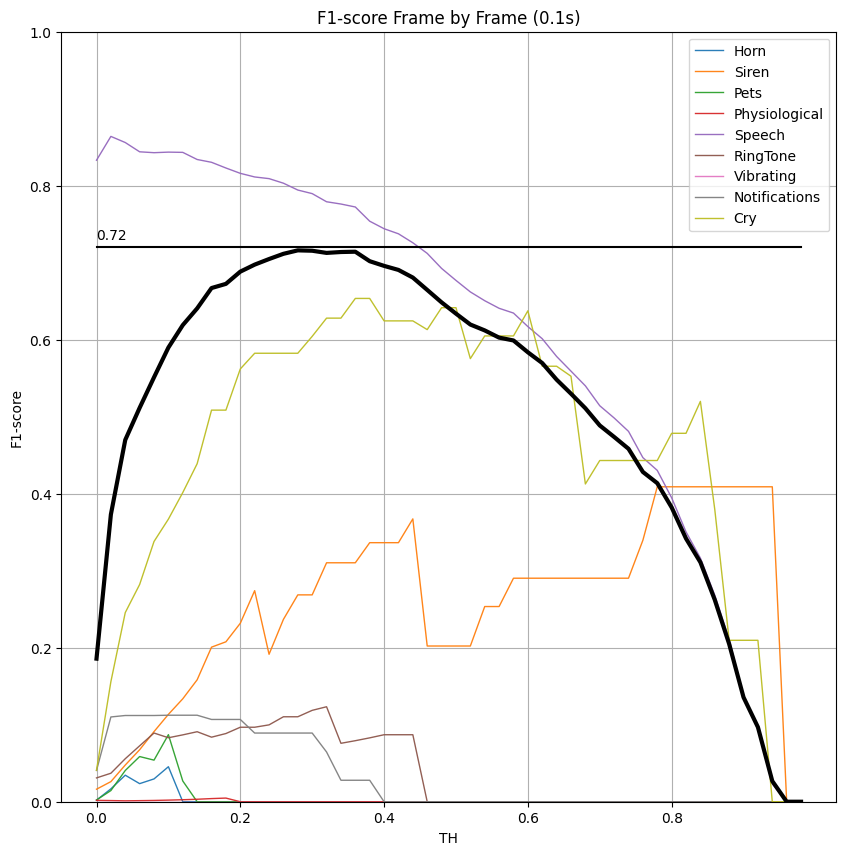

In [42]:
#F1-score plot
plt.figure(figsize=(10,10))
for f in f1_list_th.T[:-1]:
    plt.plot(f, alpha=0.95, linewidth=1)

plt.plot(np.zeros(len(f1_list_th.T[-1]))+np.round(np.max(f1_list_th.T[-1]),2), color="black")
plt.text(0,0.01+np.round(np.max(f1_list_th.T[-1]),2),str(np.round(np.max(f1_list_th.T[-1]),2)), color="black")

plt.plot(f1_list_th.T[-1], alpha=1, color="Black", linewidth=3)
plt.title("F1-score Frame by Frame (0.1s)")
plt.xlabel("TH")
plt.ylabel("F1-score")
plt.xticks(np.arange(0,len(f1_list_th),10),np.round(np.arange(0,1,0.2),2))
plt.ylim(0,1)
plt.legend(classes)
plt.grid()
plt.savefig(fold_save+"f1.png")
plt.show()

np.save(fold_save+"f1",f1_list_th.T[-1])


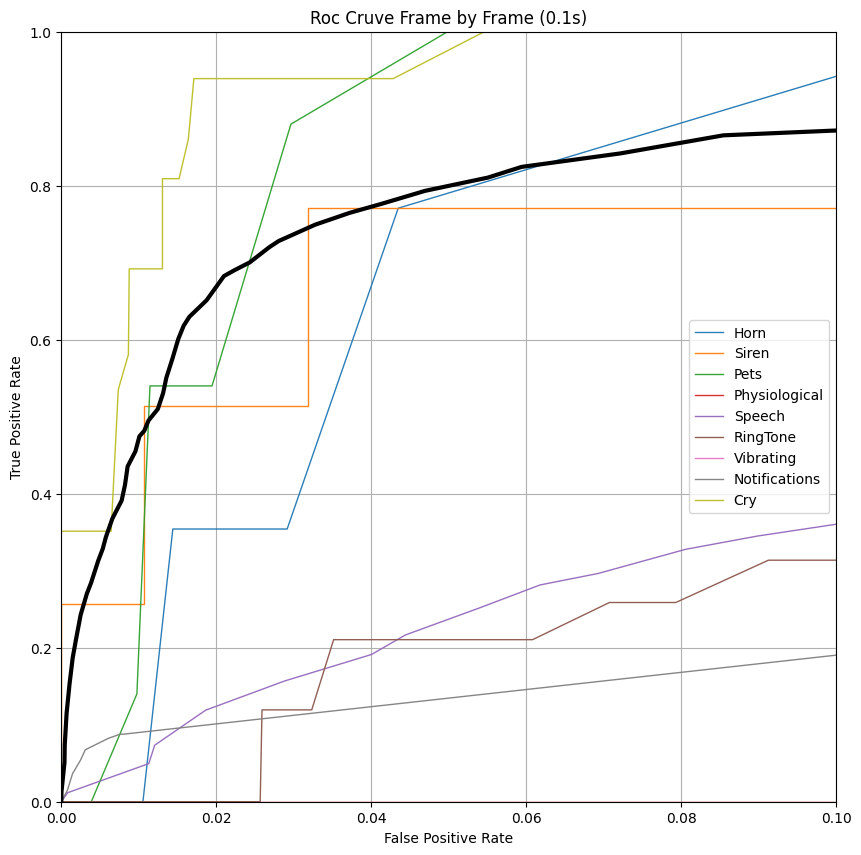

In [43]:
#Roc curve plot
plt.figure(figsize=(10,10))
fpr_list_th=np.array(fpr_list_th)
recall_list_th=np.array(recall_list_th)

for f in range(len(f1_list_th.T[:-1])):
    plt.plot(fpr_list_th.T[f],recall_list_th.T[f], alpha=0.95, linewidth=1)

plt.plot(fpr_list_th.T[-1],recall_list_th.T[-1], alpha=1, color="Black", linewidth=3)
plt.title("Roc Cruve Frame by Frame (0.1s)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(classes)
plt.xlim(0,0.1)
plt.ylim(0,1)
plt.grid()
plt.savefig(fold_save+"roc.png")
plt.show()

np.save(fold_save+"fpr",fpr_list_th.T[-1])
np.save(fold_save+"tpr",recall_list_th.T[-1])


c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\psds_eval\psds.py:755: RuntimeWarning: invalid value encountered in divide
  num_gts = per_class_tp / tp_ratios
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\psds_eval\psds.py:627: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  roc_new = pd.merge(
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\psds_eval\psds.py:627: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  roc_new = pd.merge(
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\psds_eval\psds.py:627: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  roc_new = pd.merge(
c:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\psds_eval\psds.py:627: FutureWarning: DataFrame.fillna with 'method' i

dict_keys(['Cry', 'Horn', 'Notifications', 'Pets', 'Physiological', 'RingTone', 'Siren', 'Speech'])
Cry 0.64
Horn nan
Notifications nan
Pets nan
Physiological nan
RingTone nan
Siren 0.2
Speech 0.6625129802699896
0.5008376600899965


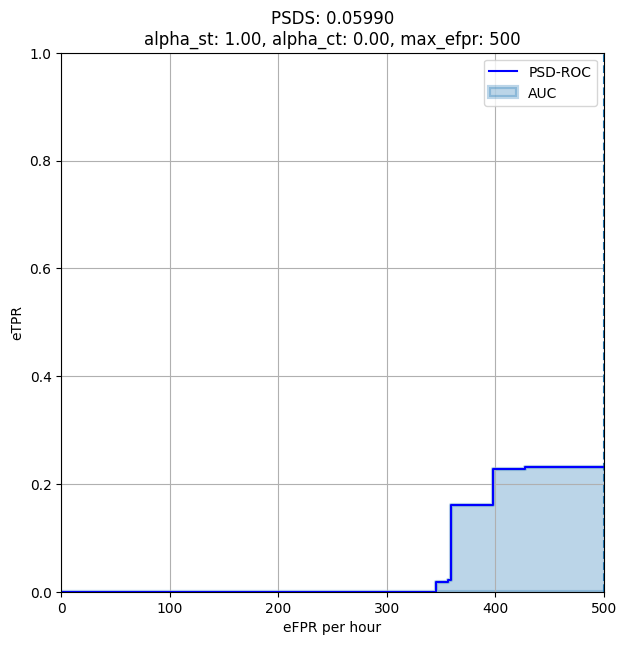

In [44]:
dtc_threshold = 0.1 #Detection Tolerance criterion (DTC):
gtc_threshold = 0.1 #Ground Truth intersection criterion (GTC)
cttc_threshold = 0.3 #Cross-Trigger Tolerance criterion (cttc)
alpha_ct = 0.0 #Cost of CTs on user experience (αCT)
alpha_st = 1.0 #Cost of instability across class (αST)
max_efpr = 500 # Maximum False Positive rate (e_max)

metadata=np.unique(labels_list[:,3])
dur=np.zeros(len(metadata))+10
groundtruth=pd.DataFrame(labels_list,columns=["onset","offset","event_label","filename"])
groundtruth["offset"]=groundtruth["offset"].astype(float)
groundtruth["onset"]=groundtruth["onset"].astype(float)
groundtruth.sort_values('filename')

metadata=pd.DataFrame(metadata,columns=["filename"])
metadata["duration"]=dur

psds_eval = PSDSEval(dtc_threshold, gtc_threshold,ground_truth=groundtruth, metadata=metadata)
psds_eval.clear_all_operating_points()

p=pd.DataFrame(predictions_list,columns=["onset","offset","event_label","th","filename"])
p["offset"]=p["offset"].astype(float)
p["onset"]=p["onset"].astype(float)
p["th"]=p["th"].astype(float)


for th in np.arange(0,1,0.2):
    th=np.round(th,2)
    det=p[p['th']>th]
    det=filtrar(det)
    det= det.sort_values('filename')
    info = {"name": f"Op {i + 1:02d}", "threshold": th}
    psds_eval.add_operating_point(det, info=info)

det=p[p['th']>=0.5]
det=filtrar(det)
f_score=psds_eval.compute_macro_f_score(det)

print(f_score[1].keys())
fs=[]
for f in f_score[1].keys():
    print(f,f_score[1][f])
    fs.append(f_score[1][f])
print(f_score[0])

fs=np.array(fs)
np.save(fold_save+"f1_event",fs)
psds = psds_eval.psds(max_efpr=max_efpr, alpha_ct=alpha_ct, alpha_st=alpha_st)
plot_psd_roc(psds,filename=fold_save+"psds.png")


In [45]:
filtrar(p[p['th']>=0.01])['event_label'].unique()

array(['Cry', 'Horn', 'Notifications', 'Pets', 'Physiological',
       'RingTone', 'Siren', 'Speech', 'Vibrating'], dtype=object)

In [46]:
groundtruth['event_label'].unique()

array(['Speech', 'Notifications', 'Physiological', 'Pets', 'RingTone',
       'Horn', 'Cry', 'Siren'], dtype=object)